In [1]:
%load_ext autoreload

%autoreload 2

import matplotlib.pyplot as plt
import yaml
import numpy as np
from ruspy.simulation.simulation import simulate
from ruspy.estimation.estimation_cost_parameters import calc_fixp
from ruspy.estimation.estimation_cost_parameters import lin_cost
from ruspy.estimation.estimation_cost_parameters import cost_func
from ruspy.estimation.estimation_cost_parameters import create_transition_matrix

In [2]:
beta = 0.9999
num_buses = 100
num_periods = 80000
gridsize = 2500
# We use the cost parameters and transition probabilities from the replication
params = np.array([10.07780762,  2.29417622])
trans_probs = np.array([0.39189182, 0.59529371, 0.01281447])

init_dict= {
    'simulation':{
        'beta': beta,
        'periods': num_periods,
        'seed': 123,
        'buses': num_buses,
        'maint_func': 'linear',
        'known_trans': trans_probs,
        'params': params,
    },
    'plot':{
        'gridsize': gridsize
    }
}

In [3]:
num_states = 200
costs = cost_func(num_states, lin_cost, init_dict["simulation"]["params"])

trans_mat = create_transition_matrix(num_states, trans_probs)
ev = calc_fixp(num_states, trans_mat, costs, beta)

In [4]:
df = simulate(init_dict["simulation"], ev, trans_mat)

In [5]:
def discount_utility(df, max_period, beta):
    v = 0.0
    for i in df.index.levels[0]:
        v += np.sum(np.multiply(beta ** np.arange(max_period), df.xs([i]).loc[:max_period - 1, "utilities"]))
    return v / len(df.index.levels[0])

In [6]:
num_points = int(num_periods / gridsize) + 1

v_exp = np.full(num_points, ev[0])

periods = np.arange(0, num_periods + gridsize, gridsize)

v_disc = np.zeros_like(periods)
for i, period in enumerate(periods[1:]):
    v_disc[i + 1] = discount_utility(df, period, beta)

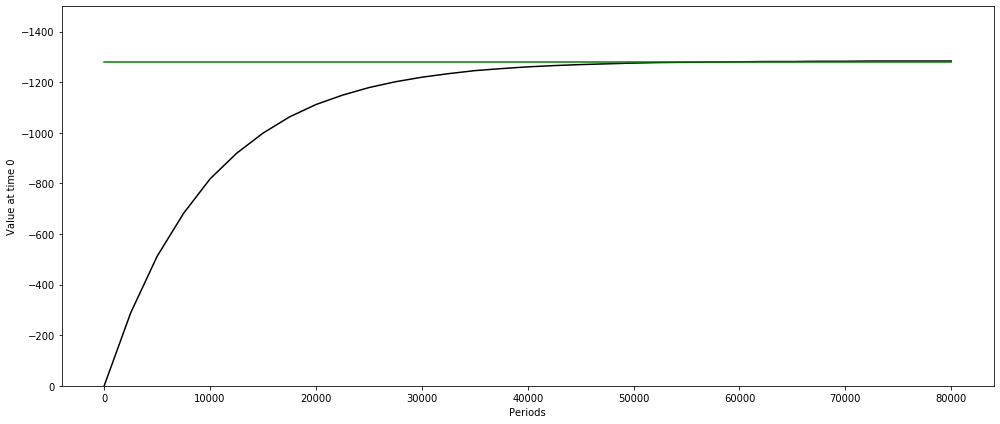

In [7]:
ax = plt.figure(figsize=(14, 6))

ax1 = ax.add_subplot(111)

ax1.set_ylim([0, -1500])

ax1.set_ylabel(r"Value at time 0")
ax1.set_xlabel(r"Periods")

ax1.plot(periods, v_disc, color="k")
ax1.plot(periods, v_exp, color="green")

plt.tight_layout()

plt.savefig("figure_1.png", dpi=300)